# Tarea programada - Tópicos de Astronomía y astrofísica
# Carlos Luis Arias Arguedas 2019065209
# Miguel Andrés Araya James 2019045001

Estas son las bibliotecas que deben ser instaladas para que el código corra con la versión de Jupyter que se descarga

In [1]:
#! pip install astroquery
#! pip install sunpy
#! pip install zeep
#! pip install drms
#! pip install glymur

Se importan las librerías relevantes 

In [2]:
import matplotlib.pyplot as plt       #Graficación
from astroquery.vizier import Vizier  #Búsqueda en bases de datos astronómicos

import astropy.units as u             #Sistema de unidades necesario
from astropy.coordinates import Distance, SkyCoord  #Funciones para convertir entre sistemas de coordenadas
from sunpy.coordinates.ephemeris import get_body_heliographic_stonyhurst, get_horizons_coord #Correccion a la posicion de 
                                                                                             #SOHO
from astropy.time import Time        #maneja el tiempo de observación del sol entre funciones

import sunpy.map                     #Preparación de la información descargada para ser usada en otras funciones de sunpy
from sunpy.coordinates import get_body_heliographic_stonyhurst #Obtención de las coordendas en el sistema heliographic 
                                                                #Stonyhurst de los objetos 
from sunpy.net import helioviewer    #Conexión con la aplicación Helioviewer para descarga de imágenes

Se genera una conexión con https://helioviewer.org/ de donde es posible espeficar el satélite, instrumento, detector y fecha para descargar los datos relacionados con esa observación

In [3]:
hv = helioviewer.HelioviewerClient()
f = hv.download_jp2('2021/05/30 03:28', observatory='SOHO',
                        instrument='LASCO', detector='C3')
lasco = sunpy.map.Map(f)


INFO: Connection to https://api.helioviewer.org/ failed. Retrying with different url. [sunpy.net.helioviewer]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

### Sistemas de coordenadas

Para el instrumento y detecto seleccionados, hay que realizar una corrección en su posición de observador. Esto se debe a que el satélite SOHO está en una órbita alrededor de un punto de Lagrange del sol. Más información aquí https://docs.sunpy.org/en/stable/generated/gallery/units_and_coordinates/getting_lasco_observer_location.html#sphx-glr-generated-gallery-units-and-coordinates-getting-lasco-observer-location-py 

In [4]:
soho = get_horizons_coord('SOHO', lasco.date)
lasco.meta['HGLN_OBS'] = soho.lon.to('deg').value
lasco.meta['HGLT_OBS'] = soho.lat.to('deg').value
lasco.meta['DSUN_OBS'] = soho.radius.to('m').value

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


Aquí se obtiene la posición del satélite en función de un sistema de coordenadas heliocéntrico

In [5]:
sun_to_soho = lasco.observer_coordinate.transform_to('hcrs')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Luego, es necesario invertir este vector para tener uno que apunte desde SOHO hasta el sol. El atributo frame contiene la información relevante al análisis en el sistema de coordenadas heliocéntrico. 

In [6]:
soho_to_sun = SkyCoord(-sun_to_soho.spherical, obstime=sun_to_soho.obstime, frame='hcrs')

### Búsqueda de las estrellas

Se extrae la información del catálogo de estrellas Vizier, donde se específica la luminosidad de las estrellas que se desean buscar y el radio máximo en el cual se deben buscar las estrellas. 

In [7]:
vv = Vizier(columns=['**'], row_limit=-1, column_filters={'Gmag': '<8'}, timeout=1200)
vv.ROW_LIMIT = -1
result = vv.query_region(soho_to_sun, radius=7 * u.deg, catalog='I/345/gaia2')

Podemos imprimir la cantidad de estrellas encontradas por la búsqueda 

In [8]:
print(len(result[0]))

241


Ahora, se cargan todas las estrellas en un arreglo de coordenadas. Se actualiza la posición al momento de la observación del instrumento.

In [9]:
tbl_crds = SkyCoord(ra=result[0]['RA_ICRS'],
                    dec=result[0]['DE_ICRS'],
                    distance=Distance(parallax=u.Quantity(result[0]['Plx']),allow_negative=True),
                    pm_ra_cosdec=result[0]['pmRA'],
                    pm_dec=result[0]['pmDE'],
                    radial_velocity=result[0]['RV'],
                    frame='icrs',
                    obstime=Time(result[0]['Epoch'], format='jyear'))
tbl_crds = tbl_crds.apply_space_motion(new_obstime=lasco.date)

C:\ProgramData\Anaconda3\lib\site-packages\erfa\core.py:4809: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
C:\ProgramData\Anaconda3\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 100 of "solution didn't converge (Note 8)", 5 of "binary logical OR of the above warnings"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


### Graficación

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


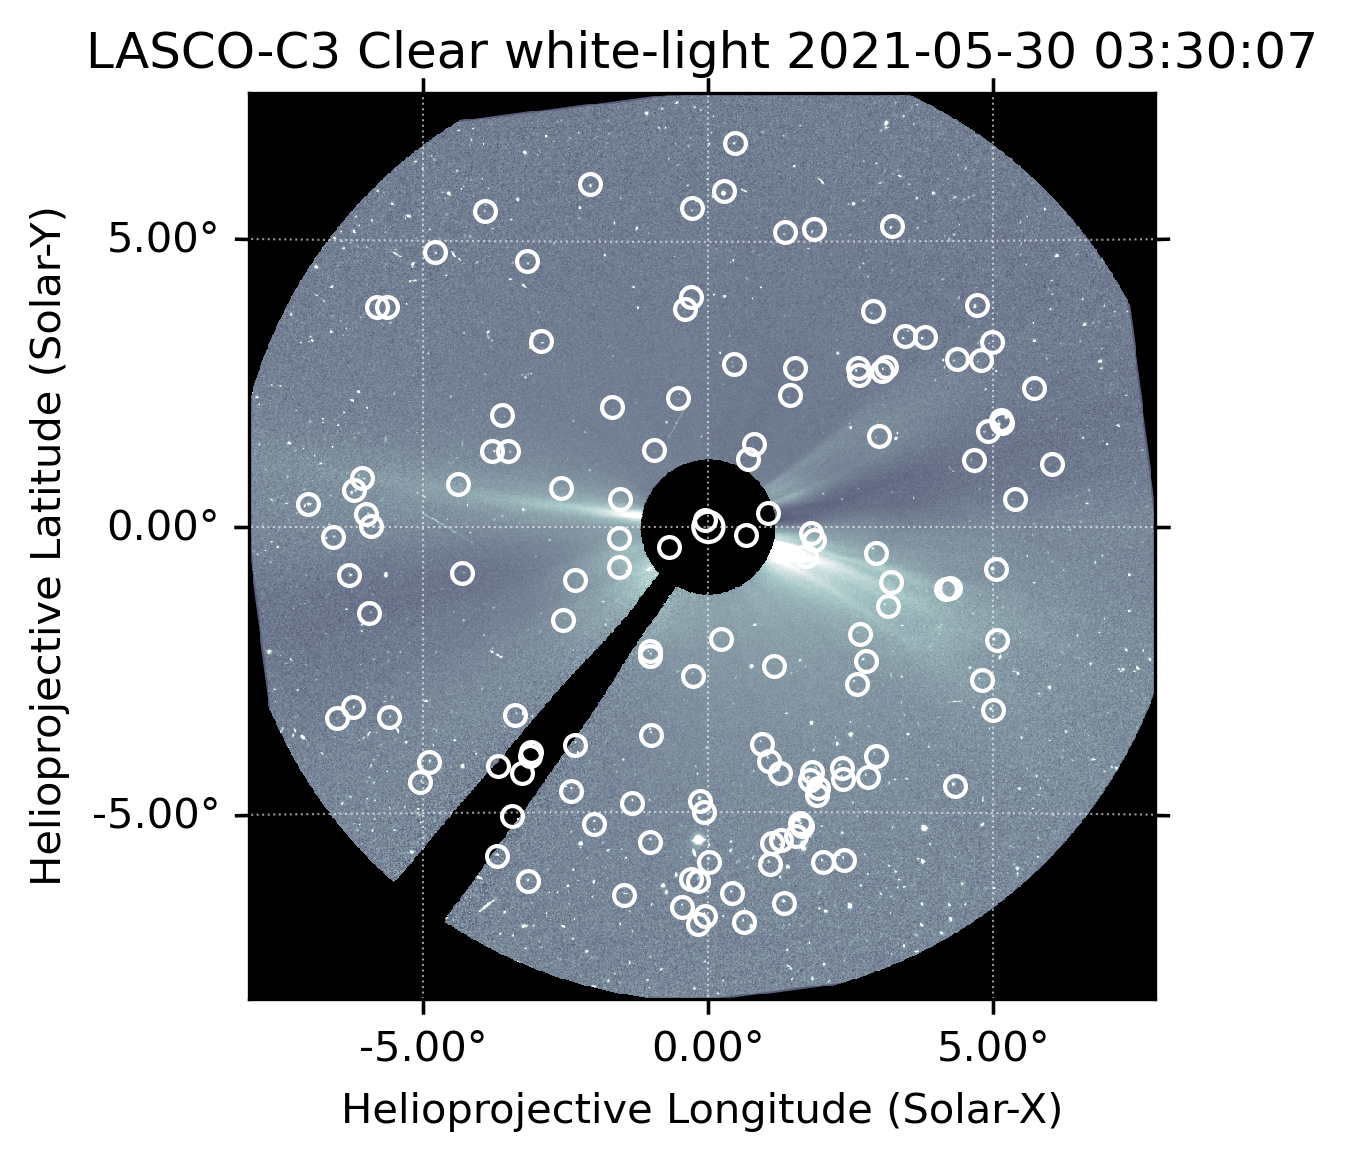

In [10]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot( projection=lasco)
# Cambio de los ejes para presentarlos en grados en vez de arcosegundos
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lasco.plot(axes=ax, vmin=0, vmax=200)
lasco.draw_limb(axes=ax)

# Plot all of the stars
ax.plot_coord(tbl_crds, 'o', color='white', fillstyle='none', markersize='5')

plt.show()